In [ ]:
"""
Produce a CMB map from 4 Planck frequencies (100, 143, 217, 353). 
Foregrounds: All extragalactic (tSZ, kSZ, CIB, RG) foregrounds simulated as a simple Guassian using SPT-SZ George et al. 2015 data.
Noise: Planck HFI Nl caculated using Half difference maps.
"""

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
from pylab import *
from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
rcParams['figure.dpi'] = 150
rcParams["figure.facecolor"] = 'white'
try:
    import os
    rc('text.latex',preamble=r'\usepackage{%s/apjfonts}' %(str(os.getcwd())))
except:
    pass

In [ ]:
import argparse, sys, numpy as np, scipy as sc, warnings, os, healpy as H
sys.path.append('/Users/sraghunathan/Research/SPTPol/analysis/git/tools/')
#or look into https://github.com/sriniraghunathan/tools
import flatsky, tools, misc
import ilc, foregrounds as fg

import matplotlib.cbook
warnings.filterwarnings('ignore',category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=matplotlib.cbook.mplDeprecation)

In [4]:
#some constants
h=6.62607004e-34 #Planck constant in m2 kg / s
k_B=1.38064852e-23 #Boltzmann constant in m2 kg s-2 / K-1
Tcmb = 2.73 #Kelvin

In [5]:
#params
paramfile = 'params.ini'
freqarr = [100, 143, 217, 353]
'''
beamarr= [2.3, 1.5, 1.0]#, 0.8]
noisearr_T = [2.0, 2.0, 6.9]#, 16.7]
#elkneearr_T = [2154., 4364., 7334.]#, 7308.]
elkneearr_T = [-1,-1,-1]#, -1]
alphakneearr_T = [3.5, 3.5, 3.5]#, 3.5]

noisearr_P = [2.9, 2.8, 9.8]#, 23.6]
elkneearr_P = [700., 700., 700.]#, 700.]
alphakneearr_P = [1.4, 1.4, 1.4]#, 1.4]
'''
lmax = 2500
freqcalib_fac = None
final_comp = 'CMB'
TParr = ['T']#, 'P']
ignore_fg = [final_comp]
verbose = 0

#beam and noise file
planck_nl_bl_file = 'planck_DR2_nl_lmax2500_no_noisemaps_20200323.npy'
beam_dic = {30:32.239, 44:27.005, 70:13.252, 100:9.651, 143:7.248, 217:4.990 , 353:4.818, 545:4.682, 857:4.325}


#for plotting
colordic = {100: 'darkblue', 143: 'green', 217: 'goldenrod', 353: 'darkred'}

In [6]:
# read and store param dict
param_dict = misc.fn_get_param_dict(paramfile)
param_dict['lmax'] = lmax
el = np.arange(param_dict['lmax'])

In [7]:
#Planck nl and bl
planck_dic = np.load(planck_nl_bl_file, allow_pickle=1, encoding = 'latin1').item()

In [22]:
#get noise spectra nl
nl_dic_full = planck_dic['nl_dic']
nl_dic = {}
for freq in freqarr:
    nl_dic[freq] = nl_dic_full[freq][:lmax]
print(sorted(nl_dic.keys()))

[100, 143, 217, 353]


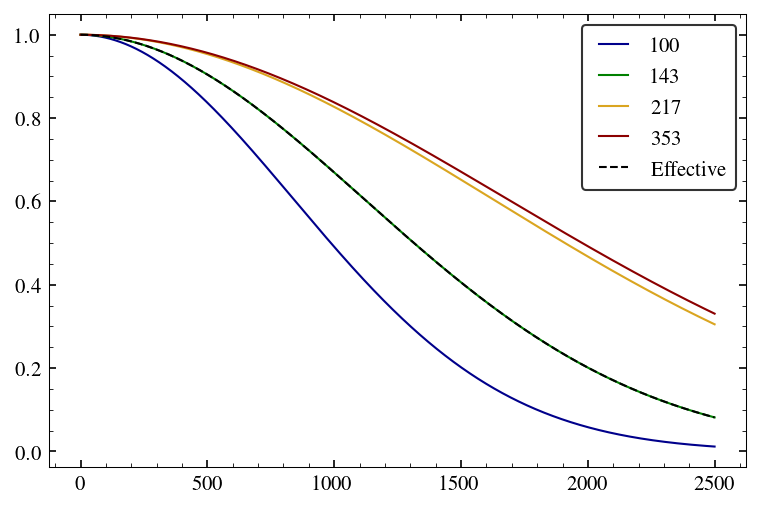

In [23]:
#get beam bl
bl_dic_full = planck_dic['bl_dic']
bl_dic = {}
for freq in freqarr:
    bl_dic[freq] = bl_dic_full[freq][:lmax]

bl_dic['effective'] = bl_dic[143][:lmax]

for freq in freqarr:
    plot(bl_dic[freq], color = colordic[freq], label = freq)
plot(bl_dic['effective'], 'k--', label = r'Effective')
legend(loc = 1)


In [24]:
#beam deconvolved noise
nl_dic_beam_deconv  = {}
for freq in freqarr:
    nl_dic_beam_deconv[freq] = nl_dic[freq] / (bl_dic[freq]**2.)

In [11]:
#get the CMB, noise, and foreground covriance
try:
    ignore_fg = param_dict['ignore_fg']
except:
    ignore_fg = []

#ignore_fg.append(final_comp) #the required component need not go into the covariance matrix.

el, cl_dic = ilc.get_covariance_dic(param_dict, freqarr, nl_dic = nl_dic_beam_deconv, ignore_fg = ignore_fg)
print(cl_dic.keys())

dict_keys([(100, 100), (100, 143), (100, 217), (100, 353), (143, 100), (143, 143), (143, 217), (143, 353), (217, 100), (217, 143), (217, 217), (217, 353), (353, 100), (353, 143), (353, 217), (353, 353)])


In [12]:
#foreground only to create Gaussian realisations of foreground maps
cl_fg_dic = {}

el, cl_ksz = fg.get_foreground_power_george_2015('kSZ', freq1 = param_dict['freq0'], freq2 = param_dict['freq0'])

for freq1 in sorted(freqarr):

    #get dust
    el,  cl_dg_po, cl_dg_clus = fg.get_cl_dust(freq1, freq1, freq0 = param_dict['freq0'], fg_model = param_dict['fg_model'], spec_index_dg_po = param_dict['spec_index_dg_po'], spec_index_dg_clus = param_dict['spec_index_dg_clus'], Tcib = param_dict['Tcib'])

    #get tsz
    el, cl_tsz = fg.get_cl_tsz(freq1, freq1, freq0 = param_dict['freq0'], fg_model = param_dict['fg_model'])

    #get radio
    el, cl_radio = fg.get_cl_radio(freq1, freq1, freq0 = param_dict['freq0'], fg_model = param_dict['fg_model'], spec_index_rg = param_dict['spec_index_rg'])
    
    cl_fg = cl_tsz + cl_ksz + cl_dg_po + cl_dg_clus + cl_radio

    cl_fg = np.concatenate( (np.zeros(param_dict['lmin']), cl_fg) )
    el = np.arange(len(cl_fg))
    
    cl_fg[np.isnan(cl_fg)] = 0.
    cl_fg[np.isinf(cl_fg)] = 0.

    cl_fg = cl_fg[:param_dict['lmax']]
    el = el[:param_dict['lmax']]


    cl_fg_dic[freq1] = cl_fg


In [13]:
#read Cls now
lmax = param_dict['lmax']
camb_file = param_dict['Dlfile_len']
el_camb = np.loadtxt(camb_file, usecols = [0])
dl_camb = np.loadtxt(camb_file, usecols = [1,2,3,4])
el_camb = el_camb[:lmax]
dl_camb = dl_camb[:lmax]

cl_camb = ( Tcmb**2. * dl_camb * 2 * np.pi ) / ( el_camb[:,None] * (el_camb[:,None] + 1) )
cl_camb *= 1e12
cl_TT, cl_EE, cl_BB, cl_TE = cl_camb.T

print(len(el_camb))

2500


Text(0, 0.5, '$C_{\\ell}$')

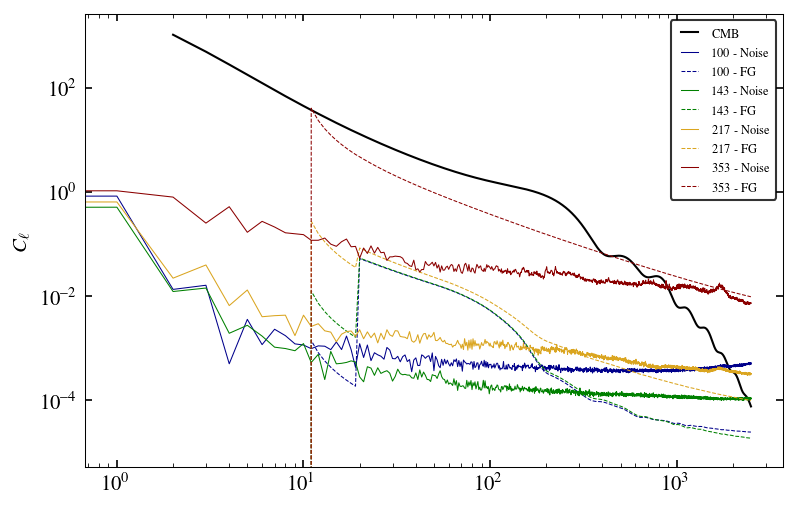

In [14]:
#plot
ax =subplot(111, yscale = 'log', xscale = 'log')
plot(el_camb, cl_TT, 'k-', label = r'CMB')
for freq in freqarr:
    plot(el, nl_dic[freq], label = r'%s - Noise' %(freq), color = colordic[freq], lw=0.5) 
    plot(el, cl_fg_dic[freq], label = r'%s - FG' %(freq), color = colordic[freq], ls = '--', lw=0.5)
legend(loc = 1, fontsize = 6)
#ylim(1e-7, 1e-5)
ylabel(r'$C_{\ell}$')

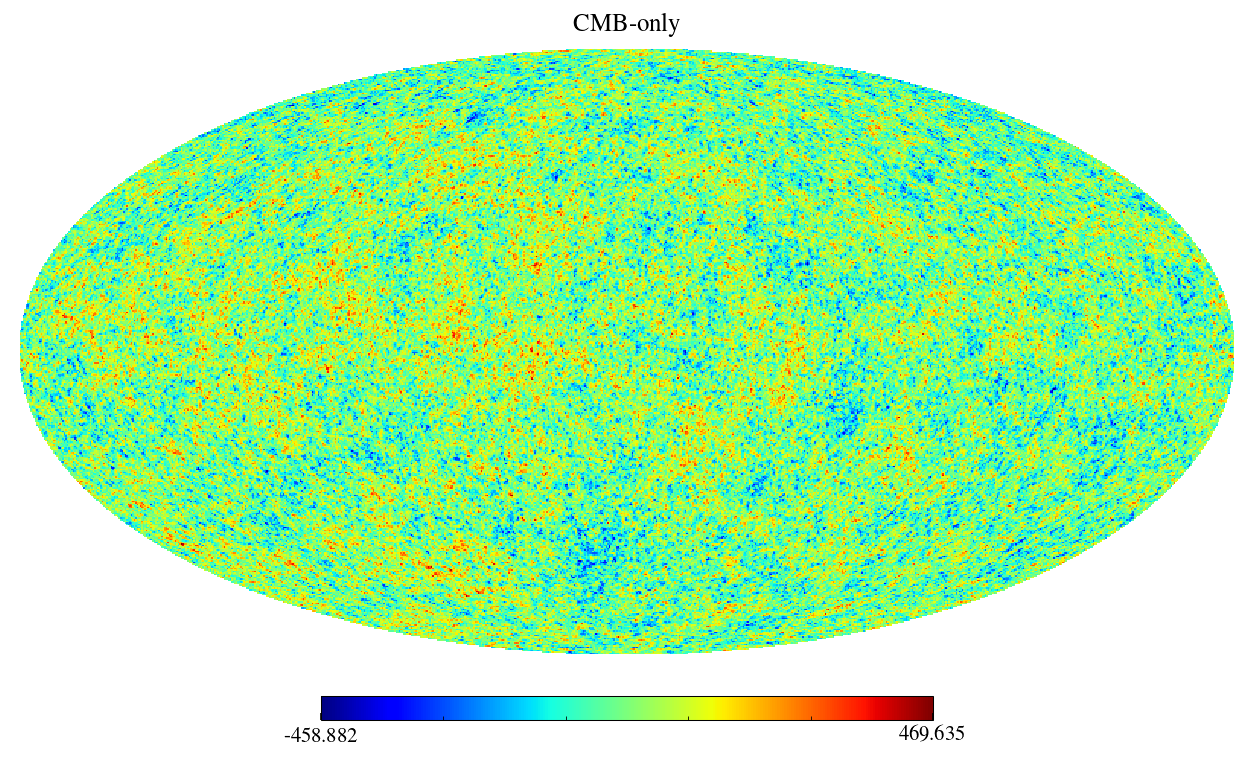

In [15]:
#create CMB map now
cmb_map = H.synfast(cl_TT, nside = param_dict['nside'], lmax = param_dict['lmax'], verbose = verbose)
cmb_map_input = np.copy(cmb_map)
H.mollview(cmb_map, title = r'CMB-only')

Random seed is 43


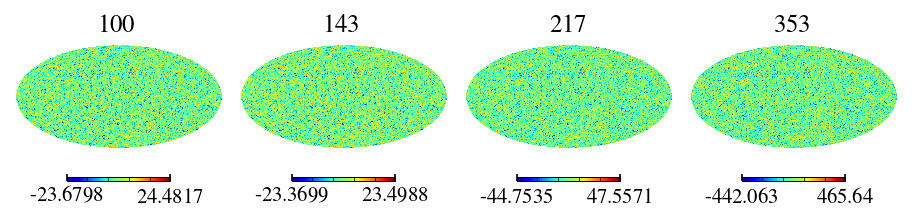

In [16]:
#create correlated foregrounds now
random_seed_fg = abs(int(cmb_map[0]))+1 ##834872
print('Random seed is %s' %(random_seed_fg))
fg_map_dic = {}
for fcnt, freq in enumerate( freqarr ):
    np.random.seed( random_seed_fg ) #correalted foregrounds
    fg_map = H.synfast(cl_fg_dic[freq], nside = param_dict['nside'], lmax = param_dict['lmax'], verbose = verbose)
    fg_map_dic[freq] = fg_map
    H.mollview(fg_map, title = r'%s' %(freq), sub = (1,len(freqarr),fcnt+1))    

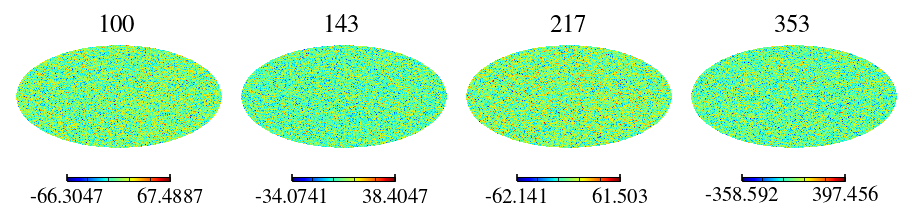

In [17]:
#create noise maps now
noise_map_dic = {}
for fcnt, freq in enumerate( freqarr ):
    noise_map = H.synfast(nl_dic[freq], nside = param_dict['nside'], lmax = param_dict['lmax'], verbose = verbose)
    noise_map_dic[freq] = noise_map
    H.mollview(noise_map, title = r'%s' %(freq), sub = (1,len(freqarr),fcnt+1))

In [18]:
#create combined maps now
map_dic = {}
for freq in freqarr:
    #combine CMB and FG
    cmb_fg_map_this_freq = np.copy(cmb_map) + fg_map_dic[freq]

    #Smooth
    beamval = beam_dic[freq]
    cmb_fg_map_this_freq = H.smoothing(np.copy(cmb_fg_map_this_freq), fwhm = np.radians(beamval/60.), lmax = lmax, verbose = verbose)

    #add noise map to it
    map_dic[freq] = cmb_fg_map_this_freq + noise_map_dic[freq]

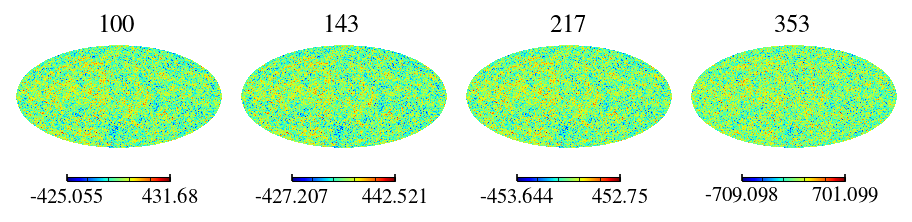

In [19]:
#show maps
for cntr, freq in enumerate( freqarr ):
    H.mollview(map_dic[freq], sub = (1, len(freqarr), cntr + 1), title = freq)

In [26]:
#get ILC map now
ilc_map, weightsarr = ilc.get_ilc_map(final_comp, el, map_dic, bl_dic, param_dict['nside'], param_dict['lmax'], lmin = param_dict['lmin'], cl_dic = cl_dic, nl_dic = nl_dic, ignore_fg = ignore_fg, full_sky = 1)

(-3.0, 3.0)

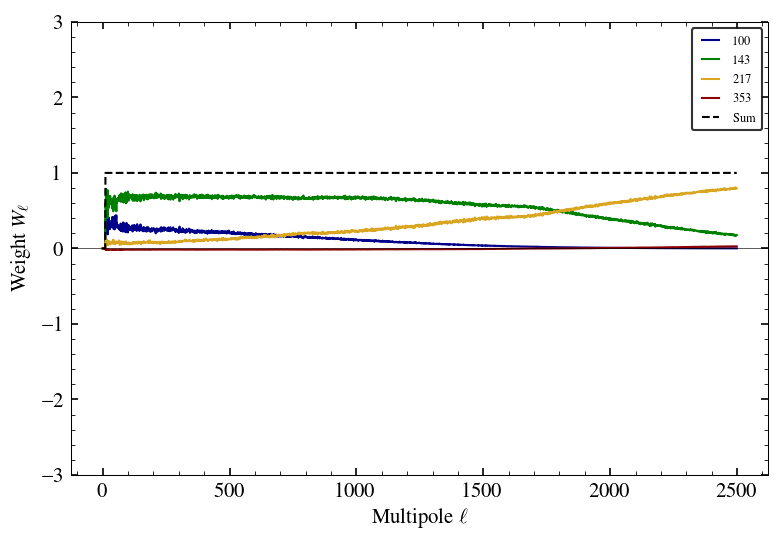

In [27]:
#plot weights now
for frqcntr, freq in enumerate( freqarr ):
    plot(weightsarr[frqcntr], color = colordic[freq], label = r'%s' %(freq))
plot(np.sum(weightsarr, axis = 0), 'k--', label = r'Sum')
axhline(lw=0.3)
legend(loc = 1, fontsize = 6)
xlabel(r'Multipole $\ell$')
ylabel(r'Weight $W_{\ell}$')
ylim(-3., 3.)

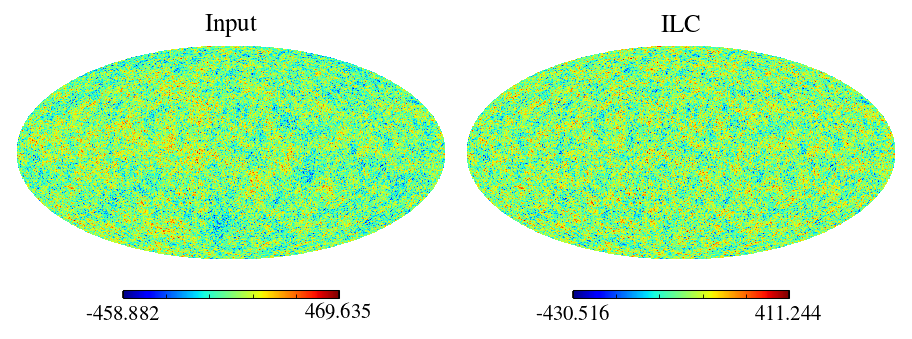

In [28]:
H.mollview(cmb_map_input, sub = (1,2,1), title = r'Input')
H.mollview(ilc_map, sub = (1,2,2), title = r'ILC')

In [43]:
#CMB imput map smoothed
beamval = beam_dic[143]
cmb_map_input_smoothed = H.smoothing(np.copy(cmb_map_input), fwhm = np.radians(beamval/60.), lmax = lmax, verbose = verbose)

In [44]:
#Cls of input and output
Cls_cross_ilc = H.anafast(ilc_map, lmax = lmax)
Cls_150 = H.anafast(map_dic[143], lmax = lmax)
Cls_cross_ip_op = H.anafast(cmb_map_input_smoothed, ilc_map, lmax = lmax)

In [45]:
#add beams
Cls_cross_ilc = Cls_cross_ilc[:lmax]
Cls_150 = Cls_150[:lmax]
Cls_cross_ip_op = Cls_cross_ip_op[:lmax]

Cls_cross_ilc = Cls_cross_ilc / bl_dic[143]**2.
Cls_150 = Cls_150 / bl_dic[143]**2.
Cls_cross_ip_op = Cls_cross_ip_op / bl_dic['effective']**2.

(0.1, 10000.0)

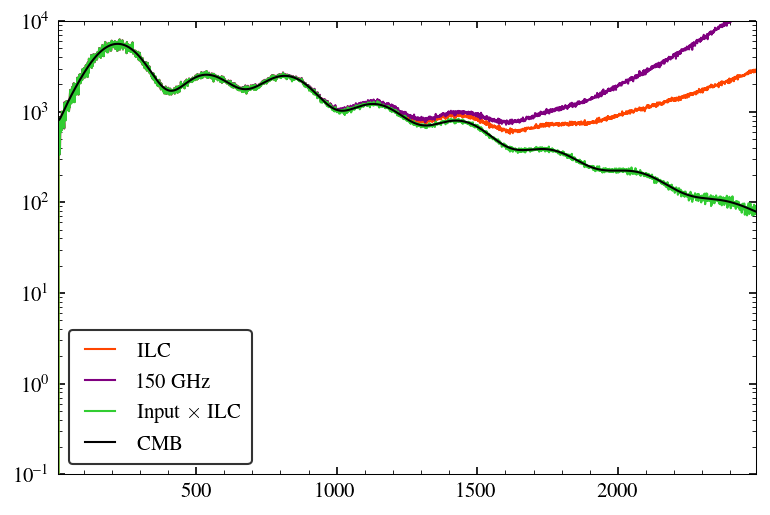

In [46]:
ax = subplot(111, yscale = 'log')#, xscale = 'log')
els_ = np.arange(len(Cls_cross_ilc))
Dls_fac = (els_ * (els_ + 1)) / 2 / np.pi
plot(Dls_fac * Cls_cross_ilc, 'orangered', label = r'ILC')
plot(Dls_fac * Cls_150, 'purple', label = r'150 GHz')
plot(Dls_fac * Cls_cross_ip_op, 'limegreen', label = r'Input $\times$ ILC')

Dls_fac = (el_camb * (el_camb + 1)) / 2 / np.pi
plot(el_camb, Dls_fac * cl_TT, 'k-', label = r'CMB')

legend(loc=3)
xlim(param_dict['lmin'], param_dict['lmax']-10); ylim(1e-1, 1e4)